In [1]:
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

### Build the ADNI training dataset
I need to load the core spreadsheet, and load the extra spreadsheet where required
Then I need to match the IDs. THen we have a spreadsheet that we can fit a logistic regression model with

In [2]:
ADNI_core_df = pd.read_csv("umap_data_spreadsheets/ADNI/clinscore_data.csv")

In [3]:
ADNI_core_df

,Unnamed: 0,Patient ID,AGE,Ventricles_bl %,Hippocampus_bl %,WholeBrain_bl %,Entorhinal_bl %,Fusiform_bl %,MidTemp_bl %,BMI,...,DX.bl_1,DX.bl_2,DX.bl_3,CV RISK FACTORS_0,CV RISK FACTORS_1,CV RISK FACTORS_2,APOE4_0,APOE4_1,APOE4_2,totatal_fazekas
0,0,002_S_0729,-0.907124,-0.599118,0.209110,0.410522,-0.386959,0.803329,0.252266,-0.935346,...,0,1,0,0,1,0,0,1,0,4.0
1,1,002_S_1155,-1.913287,-1.640056,-2.956800,-3.247881,-2.848414,-3.151439,-3.172560,-0.778481,...,0,1,0,0,1,0,1,0,0,1.0
2,2,002_S_1261,-0.080140,0.097730,-0.155410,0.197169,-0.629183,0.049800,0.232463,-0.908899,...,0,0,0,0,0,1,1,0,0,2.0
3,3,002_S_1280,-0.135273,-0.490720,0.148831,0.182368,0.396004,0.125605,-0.024744,2.393686,...,0,0,0,0,0,1,0,1,0,5.0
4,4,002_S_2010,-1.210351,-0.724175,0.889532,0.357138,0.261112,0.243122,0.582234,3.287072,...,1,0,0,0,1,0,0,1,0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
278,278,941_S_4255,0.099039,0.032813,-0.126676,0.208292,0.009422,0.287841,0.377825,0.013404,...,0,0,0,1,0,0,0,1,0,1.0
279,279,941_S_4292,-0.107707,-0.280526,0.599915,0.374701,0.714687,0.126096,0.437157,-0.017095,...,0,0,0,0,1,0,1,0,0,1.0
280,280,941_S_4365,1.187900,1.205062,-0.016664,0.101020,0.432068,0.203846,-0.216243,-0.803431,...,0,0,0,0,0,1,1,0,0,2.0
281,281,941_S_4376,0.664144,-1.640056,-2.956800,-3.247881,-2.848414,-3.151439,-3.172560,0.442142,...,0,0,0,0,1,0,1,0,0,4.0


In [4]:
def load_model_output_stats(output_type, threshold, fields=None):
    df = pd.read_csv(f"umap_data_spreadsheets/ADNI/CHAL_BASED_{output_type}_{threshold}.csv")
    if fields != None:
        return df[fields]
    return df

In [5]:
ent03 = load_model_output_stats("ent", 0.3)

In [6]:
ent03.keys()

Index(['Unnamed: 0', 'ID', 'cc_num', 'cc_unsegmented_ccs', 'cc_size_mean',
       'cc_size_std', 'cc_size_skew', 'cc_size_kurt', 'cc_vd_mean',
       'cc_vd_std', 'cc_vd_skew', 'cc_vd_kurt', 'sum', 'mean', 'std', 'skew',
       'kurtosis', 'prop_umap_segmented', 'prop_umap_within_expanded_seg',
       'prop_seg_uncertain', 'dist_mean', 'dist_std', 'dist_skew', 'dist_kurt',
       'dist_value_joint_0', 'dist_value_joint_1', 'dist_value_joint_2',
       'dist_value_joint_3', 'dist_value_joint_4', 'dist_value_joint_5',
       'dist_value_joint_6', 'dist_value_joint_7', 'dist_value_joint_8',
       'dist_value_joint_9', 'dist_value_joint_10', 'dist_value_joint_11',
       'dist_value_joint_12', 'dist_value_joint_13', 'dist_value_joint_14',
       'dist_value_joint_15', 'dist_value_joint_16', 'dist_value_joint_17',
       'dist_value_joint_18', 'dist_value_joint_19', 'dist_value_joint_20',
       'dist_value_joint_21', 'dist_value_joint_22', 'dist_value_joint_23',
       'dist_value_joint_2

In [7]:
def merge_datasets(core_df, output_types, thresholds, selected_fields):
    for output_type, thresh, fields in zip(output_types, thresholds, selected_fields):
        
        extra_df = load_model_output_stats(output_type, thresh, fields) # load the specific output type at the given threshold, and select the desired fields
        
        extra_df['Patient ID'] = ["_".join(full_id.split("_")[1:4]) for full_id in extra_df['ID']] # create the patient ID column that matches the information from the main clinscore dataframe
        extra_df = extra_df.drop(columns='ID')
        # print(extra_df['Patient ID'].values)
        extra_df = extra_df.rename(columns={key: f"{output_type}{thresh}_{key}" if key != 'Patient ID' else 'Patient ID' for key in extra_df.keys()}) # modify the column name so that we know which columns belong to which input type
        
        # print(len(core_df))
        core_df = core_df.merge(extra_df, on="Patient ID")
        
    
    core_df = core_df.drop(columns='Patient ID')       
    
    return core_df

In [8]:
all_image_extracted_fields = ['cc_num', 'cc_unsegmented_ccs', 'cc_size_mean',
       'cc_size_std', 'cc_size_skew', 'cc_size_kurt', 'cc_vd_mean',
       'cc_vd_std', 'cc_vd_skew', 'cc_vd_kurt', 'sum', 'mean', 'std', 'skew',
       'kurtosis', 'prop_umap_segmented', 'prop_umap_within_expanded_seg',
       'prop_seg_uncertain', 'dist_mean', 'dist_std', 'dist_skew', 'dist_kurt',
       'dist_value_joint_0', 'dist_value_joint_1', 'dist_value_joint_2',
       'dist_value_joint_3', 'dist_value_joint_4', 'dist_value_joint_5',
       'dist_value_joint_6', 'dist_value_joint_7', 'dist_value_joint_8',
       'dist_value_joint_9', 'dist_value_joint_10', 'dist_value_joint_11',
       'dist_value_joint_12', 'dist_value_joint_13', 'dist_value_joint_14',
       'dist_value_joint_15', 'dist_value_joint_16', 'dist_value_joint_17',
       'dist_value_joint_18', 'dist_value_joint_19', 'dist_value_joint_20',
       'dist_value_joint_21', 'dist_value_joint_22', 'dist_value_joint_23',
       'dist_value_joint_24', 'cc_dist_value_joint_0', 'cc_dist_value_joint_1',
       'cc_dist_value_joint_2', 'cc_dist_value_joint_3',
       'cc_dist_value_joint_4', 'cc_dist_value_joint_5',
       'cc_dist_value_joint_6', 'cc_dist_value_joint_7',
       'cc_dist_value_joint_8', 'cc_dist_value_joint_9',
       'cc_dist_value_joint_10', 'cc_dist_value_joint_11',
       'cc_dist_value_joint_12', 'cc_dist_value_joint_13',
       'cc_dist_value_joint_14', 'cc_dist_value_joint_15',
       'cc_dist_value_joint_16', 'cc_dist_value_joint_17',
       'cc_dist_value_joint_18', 'cc_dist_value_joint_19',
       'cc_dist_value_joint_20', 'cc_dist_value_joint_21',
       'cc_dist_value_joint_22', 'cc_dist_value_joint_23',
       'cc_dist_value_joint_24', 'values_hist_0',
       'values_hist_1', 'values_hist_2', 'values_hist_3', 'values_hist_4',
       'values_hist_5', 'values_hist_6', 'values_hist_7', 'values_hist_8',
       'values_hist_9', 'values_hist_10', 'values_hist_11', 'values_hist_12',
       'values_hist_13', 'values_hist_14', 'values_hist_15', 'values_hist_16',
       'values_hist_17', 'values_hist_18', 'values_hist_19']

pred_values = ['seg_volume', 'vent_volume']

In [9]:
added_inputs = ["pred", "ent", "pred", "var"]
thresholds = [0.5, 0.3, 0.2, 0.06]
# added_fields = [['cc_num', 'cc_unsegmented_ccs', 'cc_size_mean'], ['kurtosis', 'prop_umap_segmented', 'prop_umap_within_expanded_seg'], ['kurtosis']]
added_fields = [pred_values, all_image_extracted_fields, all_image_extracted_fields, all_image_extracted_fields]
added_fields = [f+['ID'] for f in added_fields]

included_terms = []#0]#, 2]#, 1]#, 3]
added_inputs = [added_inputs[idx] for idx in included_terms]
thresholds = [thresholds[idx] for idx in included_terms]
added_fields = [added_fields[idx] for idx in included_terms]

core_fields = ['Patient ID', 'AGE', 'Ventricles_bl %',
       'Hippocampus_bl %', 'WholeBrain_bl %', 'Entorhinal_bl %',
       'Fusiform_bl %', 'MidTemp_bl %', 'BMI', 'WMH_PV', 'WMH_Deep', 'Total',
       'PTGENDER', 'E-M RISK FACTORS', 'DX.bl_0', 'DX.bl_1', 'DX.bl_2',
       'DX.bl_3', 'CV RISK FACTORS_0', 'CV RISK FACTORS_1',
       'CV RISK FACTORS_2', 'APOE4_0', 'APOE4_1', 'APOE4_2',
       'totatal_fazekas']

In [10]:
ADNI_core_df.keys()

Index(['Unnamed: 0', 'Patient ID', 'AGE', 'Ventricles_bl %',
       'Hippocampus_bl %', 'WholeBrain_bl %', 'Entorhinal_bl %',
       'Fusiform_bl %', 'MidTemp_bl %', 'BMI', 'WMH_PV', 'WMH_Deep', 'Total',
       'PTGENDER', 'E-M RISK FACTORS', 'DX.bl_0', 'DX.bl_1', 'DX.bl_2',
       'DX.bl_3', 'CV RISK FACTORS_0', 'CV RISK FACTORS_1',
       'CV RISK FACTORS_2', 'APOE4_0', 'APOE4_1', 'APOE4_2',
       'totatal_fazekas'],
      dtype='object')

In [11]:
combined_df = merge_datasets(ADNI_core_df[core_fields], added_inputs, thresholds, added_fields)

In [12]:
combined_df

,AGE,Ventricles_bl %,Hippocampus_bl %,WholeBrain_bl %,Entorhinal_bl %,Fusiform_bl %,MidTemp_bl %,BMI,WMH_PV,WMH_Deep,...,DX.bl_1,DX.bl_2,DX.bl_3,CV RISK FACTORS_0,CV RISK FACTORS_1,CV RISK FACTORS_2,APOE4_0,APOE4_1,APOE4_2,totatal_fazekas
0,-0.907124,-0.599118,0.209110,0.410522,-0.386959,0.803329,0.252266,-0.935346,2.0,2.0,...,0,1,0,0,1,0,0,1,0,4.0
1,-1.913287,-1.640056,-2.956800,-3.247881,-2.848414,-3.151439,-3.172560,-0.778481,1.0,0.0,...,0,1,0,0,1,0,1,0,0,1.0
2,-0.080140,0.097730,-0.155410,0.197169,-0.629183,0.049800,0.232463,-0.908899,1.0,1.0,...,0,0,0,0,0,1,1,0,0,2.0
3,-0.135273,-0.490720,0.148831,0.182368,0.396004,0.125605,-0.024744,2.393686,3.0,2.0,...,0,0,0,0,0,1,0,1,0,5.0
4,-1.210351,-0.724175,0.889532,0.357138,0.261112,0.243122,0.582234,3.287072,1.0,1.0,...,1,0,0,0,1,0,0,1,0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
278,0.099039,0.032813,-0.126676,0.208292,0.009422,0.287841,0.377825,0.013404,1.0,0.0,...,0,0,0,1,0,0,0,1,0,1.0
279,-0.107707,-0.280526,0.599915,0.374701,0.714687,0.126096,0.437157,-0.017095,1.0,0.0,...,0,0,0,0,1,0,1,0,0,1.0
280,1.187900,1.205062,-0.016664,0.101020,0.432068,0.203846,-0.216243,-0.803431,1.0,1.0,...,0,0,0,0,0,1,1,0,0,2.0
281,0.664144,-1.640056,-2.956800,-3.247881,-2.848414,-3.151439,-3.172560,0.442142,2.0,2.0,...,0,0,0,0,1,0,1,0,0,4.0


### Add the sample diversity data

In [13]:
import os
data_folder = "umap_data_spreadsheets/ADNI/"
all_data_files = os.listdir(data_folder)
sample_div_files = [f for f in all_data_files if "sample_div" in f and "CHAL" in f]

dfs = [pd.read_csv(data_folder + f) for f in sample_div_files]

sample_div_df = pd.concat(dfs)

In [14]:
sample_div_df['Patient ID'] = ["_".join(full_id.split("_")[1:4]) for full_id in sample_div_df['ID']] # create the patient ID column that matches the information from the main clinscore dataframe
sample_div_df = sample_div_df.drop(columns='ID')
sample_div_df.drop(columns='Unnamed: 0')

,sample_div_std,sample_div_IQR,sample_div_skew,sample_div_vd_std,sample_div_vd_IQR,sample_div_vd_skew,Patient ID
0,817.855347,255.25,5.562082,491.890808,110.276077,5.754393,014_S_4401
1,1177.716919,366.00,6.467650,318.591583,53.133704,6.777679,014_S_4576
2,1909.486206,902.25,4.870288,222.108078,67.396593,5.272177,018_S_2155
3,857.948120,460.50,3.874431,1677.464111,886.274513,3.896058,018_S_2180
4,1814.429443,1663.00,2.478634,59.763382,37.401420,3.454792,018_S_4313
...,...,...,...,...,...,...,...
15,889.277222,474.25,5.033178,122.011925,44.616518,5.740028,006_S_4150
16,1548.871826,1200.25,2.938529,111.417175,54.193551,3.607387,006_S_4153
17,2298.214111,1294.00,3.782131,136.418427,55.979644,4.305468,006_S_4192
18,954.711609,606.50,3.265785,263.774902,138.294806,3.545413,006_S_4357


In [15]:
ADNI_core_df = ADNI_core_df.merge(sample_div_df, on="Patient ID")



In [16]:
ADNI_core_df

,Unnamed: 0_x,Patient ID,AGE,Ventricles_bl %,Hippocampus_bl %,WholeBrain_bl %,Entorhinal_bl %,Fusiform_bl %,MidTemp_bl %,BMI,...,APOE4_1,APOE4_2,totatal_fazekas,Unnamed: 0_y,sample_div_std,sample_div_IQR,sample_div_skew,sample_div_vd_std,sample_div_vd_IQR,sample_div_vd_skew
0,0,002_S_0729,-0.907124,-0.599118,0.209110,0.410522,-0.386959,0.803329,0.252266,-0.935346,...,1,0,4.0,0,1769.748901,1770.25,1.645701,37.189384,32.891414,2.833950
1,1,002_S_1155,-1.913287,-1.640056,-2.956800,-3.247881,-2.848414,-3.151439,-3.172560,-0.778481,...,0,0,1.0,1,1045.226807,382.00,4.779354,451.992371,106.584819,5.044192
2,2,002_S_1261,-0.080140,0.097730,-0.155410,0.197169,-0.629183,0.049800,0.232463,-0.908899,...,0,0,2.0,2,3267.764404,750.75,6.615671,595.460815,96.817343,6.746863
3,3,002_S_1280,-0.135273,-0.490720,0.148831,0.182368,0.396004,0.125605,-0.024744,2.393686,...,1,0,5.0,3,2553.932373,1362.25,5.179930,84.408745,33.696046,6.140611
4,4,002_S_2010,-1.210351,-0.724175,0.889532,0.357138,0.261112,0.243122,0.582234,3.287072,...,1,0,2.0,4,864.190247,320.50,5.412156,416.418030,114.285715,5.632845
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
271,278,941_S_4255,0.099039,0.032813,-0.126676,0.208292,0.009422,0.287841,0.377825,0.013404,...,1,0,1.0,5,1084.646729,646.50,3.915097,75.074387,37.220938,4.783535
272,279,941_S_4292,-0.107707,-0.280526,0.599915,0.374701,0.714687,0.126096,0.437157,-0.017095,...,0,0,1.0,6,643.801270,425.25,3.776565,128.875183,57.488989,4.540243
273,280,941_S_4365,1.187900,1.205062,-0.016664,0.101020,0.432068,0.203846,-0.216243,-0.803431,...,0,0,2.0,7,2703.340332,1097.00,4.136897,153.949799,40.429687,4.513145
274,281,941_S_4376,0.664144,-1.640056,-2.956800,-3.247881,-2.848414,-3.151439,-3.172560,0.442142,...,0,0,4.0,8,1541.462402,1180.00,2.937691,50.473885,32.184355,4.043405


In [17]:
def load_model_output_stats(output_type, threshold, fields=None):
    df = pd.read_csv(f"umap_data_spreadsheets/ADNI/{output_type}_{threshold}.csv")
    if fields != None:
        return df[fields]
    return df

In [18]:
ent03 = load_model_output_stats("ent", 0.3)

In [19]:
ent03.keys()

Index(['Unnamed: 0', 'ID', 'cc_num', 'cc_unsegmented_ccs', 'cc_size_mean',
       'cc_size_std', 'cc_size_skew', 'cc_size_kurt', 'cc_vd_mean',
       'cc_vd_std', 'cc_vd_skew', 'cc_vd_kurt', 'sum', 'mean', 'std', 'skew',
       'kurtosis', 'prop_umap_segmented', 'prop_umap_within_expanded_seg',
       'prop_seg_uncertain', 'dist_mean', 'dist_std', 'dist_skew', 'dist_kurt',
       'dist_value_joint_0', 'dist_value_joint_1', 'dist_value_joint_2',
       'dist_value_joint_3', 'dist_value_joint_4', 'dist_value_joint_5',
       'dist_value_joint_6', 'dist_value_joint_7', 'dist_value_joint_8',
       'dist_value_joint_9', 'dist_value_joint_10', 'dist_value_joint_11',
       'dist_value_joint_12', 'dist_value_joint_13', 'dist_value_joint_14',
       'dist_value_joint_15', 'dist_value_joint_16', 'dist_value_joint_17',
       'dist_value_joint_18', 'dist_value_joint_19', 'dist_value_joint_20',
       'dist_value_joint_21', 'dist_value_joint_22', 'dist_value_joint_23',
       'dist_value_joint_2

### fitting to predict fazekas

In [20]:
def merge_datasets(core_df, output_types, thresholds, selected_fields):
    for output_type, thresh, fields in zip(output_types, thresholds, selected_fields):
        
        extra_df = load_model_output_stats(output_type, thresh, fields) # load the specific output type at the given threshold, and select the desired fields
        
        extra_df['Patient ID'] = ["_".join(full_id.split("_")[1:4]) for full_id in extra_df['ID']] # create the patient ID column that matches the information from the main clinscore dataframe
        extra_df = extra_df.drop(columns='ID')
        # print(extra_df['Patient ID'].values)
        extra_df = extra_df.rename(columns={key: f"{output_type}{thresh}_{key}" if key != 'Patient ID' else 'Patient ID' for key in extra_df.keys()}) # modify the column name so that we know which columns belong to which input type
        
        # print(len(core_df))
        core_df = core_df.merge(extra_df, on="Patient ID")
        
    
    core_df = core_df.drop(columns='Patient ID')       
    
    return core_df

In [21]:
def remove_nans(dfc, verbose=False):
    nan_rows = dfc[dfc.isnull().any(axis=1)]
    nan_cols = dfc.columns[dfc.isnull().any()]
    if verbose:
        print("nans removed: ", len(nan_rows))
    dfc = dfc.drop(labels=nan_rows.index.values, axis=0)
    return dfc

In [22]:
def extract_Xy(df, label_class, verbose=False, kept_column=None, label_categories=None):
    df = remove_nans(df, verbose)
    if label_categories == None:
        label_categories = ['WMH_PV', 'WMH_Deep', 'Total', 'totatal_fazekas']
    if kept_column != None:
        y_reg = df[kept_column].values
    y = df[label_class].values
    X = df.drop(columns=label_categories)
    if label_class not in label_categories:
        X = X.drop(columns=label_class)
    if kept_column != None:
        X[kept_column] = y_reg
    return X, y

In [23]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

In [24]:
class Rescaler():
    def fit(self, X):
        norm_parameters = []
        for key in X.keys():
            values = X[key].values
            if len(np.unique(values)) > 2:
                mean = np.mean(values)
                std = np.std(values)
                norm_parameters.append((key, mean, std))
        self.norm_parameters = norm_parameters
    def predict(self, X):
        X = X.copy()
        for key, mean, std in self.norm_parameters:
            X[key] = (X[key] - mean) / std
        
        return X

In [25]:
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score

In [26]:
def shuffle(df, random_state=42):
    df = df.copy()
    df = df.sample(frac=1, random_state=random_state).reset_index(drop=True)
    return df

In [27]:
from tqdm import tqdm

## new training pipeline


configure so that I can pick a specific input type and threshold and included features.
Need the ability to include multiple sets of fields from the core df. to do this, I can combine all features into one large dataframe and then pull out only the ones I need from that. Once I have this, assess the performance, and predict Dice and F1 as well, and then summarise everything that I have done and am going to do for Maria.
I will talk about the second test using the data trained on the WMH challenge data.
Explain the limitations of the study (I need to hyperparameter tune for example).
Explain the comparison with the CNN results that I have done. Nice.

### collating all the input data types together

In [28]:
all_image_extracted_fields = ['cc_num', 'cc_unsegmented_ccs', 'cc_size_mean',
       'cc_size_std', 'cc_size_skew', 'cc_size_kurt', 'cc_vd_mean',
       'cc_vd_std', 'cc_vd_skew', 'cc_vd_kurt', 'sum', 'mean', 'std', 'skew',
       'kurtosis', 'prop_umap_segmented', 'prop_umap_within_expanded_seg',
       'prop_seg_uncertain', 'dist_mean', 'dist_std', 'dist_skew', 'dist_kurt',
       'dist_value_joint_0', 'dist_value_joint_1', 'dist_value_joint_2',
       'dist_value_joint_3', 'dist_value_joint_4', 'dist_value_joint_5',
       'dist_value_joint_6', 'dist_value_joint_7', 'dist_value_joint_8',
       'dist_value_joint_9', 'dist_value_joint_10', 'dist_value_joint_11',
       'dist_value_joint_12', 'dist_value_joint_13', 'dist_value_joint_14',
       'dist_value_joint_15', 'dist_value_joint_16', 'dist_value_joint_17',
       'dist_value_joint_18', 'dist_value_joint_19', 'dist_value_joint_20',
       'dist_value_joint_21', 'dist_value_joint_22', 'dist_value_joint_23',
       'dist_value_joint_24', 'cc_dist_value_joint_0', 'cc_dist_value_joint_1',
       'cc_dist_value_joint_2', 'cc_dist_value_joint_3',
       'cc_dist_value_joint_4', 'cc_dist_value_joint_5',
       'cc_dist_value_joint_6', 'cc_dist_value_joint_7',
       'cc_dist_value_joint_8', 'cc_dist_value_joint_9',
       'cc_dist_value_joint_10', 'cc_dist_value_joint_11',
       'cc_dist_value_joint_12', 'cc_dist_value_joint_13',
       'cc_dist_value_joint_14', 'cc_dist_value_joint_15',
       'cc_dist_value_joint_16', 'cc_dist_value_joint_17',
       'cc_dist_value_joint_18', 'cc_dist_value_joint_19',
       'cc_dist_value_joint_20', 'cc_dist_value_joint_21',
       'cc_dist_value_joint_22', 'cc_dist_value_joint_23',
       'cc_dist_value_joint_24', 'values_hist_0',
       'values_hist_1', 'values_hist_2', 'values_hist_3', 'values_hist_4',
       'values_hist_5', 'values_hist_6', 'values_hist_7', 'values_hist_8',
       'values_hist_9', 'values_hist_10', 'values_hist_11', 'values_hist_12',
       'values_hist_13', 'values_hist_14', 'values_hist_15', 'values_hist_16',
       'values_hist_17', 'values_hist_18', 'values_hist_19']

pred_values = ['seg_volume', 'vent_volume']

In [29]:
added_inps = ["pred"] + ["pred" for _ in range(6)] + ["ent" for _ in range(6)] + ["var" for _ in range(4)]
added_thresholds = [0.5, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.1, 0.2, 0.3, 0.4, 0.45, 0.5, 0.01, 0.03, 0.06, 0.09]
added_fields = [pred_values] +  [all_image_extracted_fields for _ in range(len(added_inps) - 1)]
added_fields = [f+['ID'] for f in added_fields]


adni_df_sel_fields = ['Patient ID', 'AGE', 'Ventricles_bl %',
       'Hippocampus_bl %', 'WholeBrain_bl %', 'Entorhinal_bl %',
       'Fusiform_bl %', 'MidTemp_bl %', 'BMI', 'WMH_PV', 'WMH_Deep', 'Total',
       'PTGENDER', 'E-M RISK FACTORS', 'DX.bl_0', 'DX.bl_1', 'DX.bl_2',
       'DX.bl_3', 'CV RISK FACTORS_0', 'CV RISK FACTORS_1',
       'CV RISK FACTORS_2', 'APOE4_0', 'APOE4_1', 'APOE4_2',
       'totatal_fazekas', 'sample_div_std', 'sample_div_IQR', 'sample_div_skew',
       'sample_div_vd_std', 'sample_div_vd_IQR', 'sample_div_vd_skew']

full_combined_df = merge_datasets(ADNI_core_df[adni_df_sel_fields], added_inps, added_thresholds, added_fields)

In [30]:
full_combined_df['ent0.45_values_hist_10']

0      0.048349
1      0.033839
2      0.041879
3      0.041823
4      0.042934
         ...   
267    0.054611
268    0.036348
269    0.044204
270    0.049541
271    0.041558
Name: ent0.45_values_hist_10, Length: 272, dtype: float64

In [31]:
def get_select_fields(df, fields_lists, input_types, thresholds):
    full_fields_selection = []
    for fieldset, t, inp in zip(fields_lists, thresholds, input_types):
        if inp == None:
            full_fields_selection.extend(fieldset)
        else:
            full_fields_selection.extend([f"{inp}{t}_{f}" for f in fieldset])
    
    df= df[full_fields_selection]
    
#     # Get duplicate columns names
#     dup_cols = df.columns[df.columns.duplicated()]

#     # Rename duplicate columns
#     for x in dup_cols:
#         cols = df.columns[df.columns.str.startswith(x)] 
#         for i in range(len(cols)):
#             df = df.rename(columns={cols[i]: x + '_' + str(i+1)})
            
    return df

In [64]:
clinical_fields = ['AGE', 'Ventricles_bl %',
       'Hippocampus_bl %', 'WholeBrain_bl %', 'Entorhinal_bl %',
       'Fusiform_bl %', 'MidTemp_bl %', 'BMI',
       'PTGENDER', 'E-M RISK FACTORS', 'DX.bl_0', 'DX.bl_1', 'DX.bl_2',
       'DX.bl_3', 'CV RISK FACTORS_0', 'CV RISK FACTORS_1',
       'CV RISK FACTORS_2', 'APOE4_0', 'APOE4_1', 'APOE4_2',]

target_fields = ["WMH_Deep", "WMH_PV", "Total", "totatal_fazekas"]

volume_fields = ['seg_volume', 'vent_volume']

inp_map_fields_1 = ['cc_num', 'cc_unsegmented_ccs', 'cc_size_mean',
       'cc_size_std', 'cc_size_skew', 'cc_size_kurt']

inp_map_fields_2 = ['cc_vd_mean', 'cc_vd_std', 'cc_vd_skew', 'cc_vd_kurt']

inp_map_fields_3 = ['sum', 'mean', 'std', 'skew', 'kurtosis', 'prop_umap_segmented',
       'prop_seg_uncertain', 'dist_mean', 'dist_std', 'dist_skew', 'dist_kurt']

joint_fields = [
    'dist_value_joint_0', 'dist_value_joint_1', 'dist_value_joint_2',
       'dist_value_joint_3', 'dist_value_joint_4', 'dist_value_joint_5',
       'dist_value_joint_6', 'dist_value_joint_7', 'dist_value_joint_8',
       'dist_value_joint_9', 'dist_value_joint_10', 'dist_value_joint_11',
       'dist_value_joint_12', 'dist_value_joint_13', 'dist_value_joint_14',
       'dist_value_joint_15', 'dist_value_joint_16', 'dist_value_joint_17',
       'dist_value_joint_18', 'dist_value_joint_19', 'dist_value_joint_20',
       'dist_value_joint_21', 'dist_value_joint_22', 'dist_value_joint_23',
       'dist_value_joint_24', 'cc_dist_value_joint_0', 'cc_dist_value_joint_1',
       'cc_dist_value_joint_2', 'cc_dist_value_joint_3',
       'cc_dist_value_joint_4', 'cc_dist_value_joint_5',
       'cc_dist_value_joint_6', 'cc_dist_value_joint_7',
       'cc_dist_value_joint_8', 'cc_dist_value_joint_9',
       'cc_dist_value_joint_10', 'cc_dist_value_joint_11',
       'cc_dist_value_joint_12', 'cc_dist_value_joint_13',
       'cc_dist_value_joint_14', 'cc_dist_value_joint_15',
       'cc_dist_value_joint_16', 'cc_dist_value_joint_17',
       'cc_dist_value_joint_18', 'cc_dist_value_joint_19',
       'cc_dist_value_joint_20', 'cc_dist_value_joint_21',
       'cc_dist_value_joint_22', 'cc_dist_value_joint_23',
       'cc_dist_value_joint_24', 'values_hist_0',
       'values_hist_1', 'values_hist_2', 'values_hist_3', 'values_hist_4',
       'values_hist_5', 'values_hist_6', 'values_hist_7', 'values_hist_8',
       'values_hist_9', 'values_hist_10', 'values_hist_11', 'values_hist_12',
       'values_hist_13', 'values_hist_14', 'values_hist_15', 'values_hist_16',
       'values_hist_17', 'values_hist_18', 'values_hist_19'
]

extracted_fields = [inp_map_fields_1, inp_map_fields_2, inp_map_fields_3]

umap_specific_fields = [ 'sample_div_std', 'sample_div_IQR', 'sample_div_skew',
       'sample_div_vd_std', 'sample_div_vd_IQR', 'sample_div_vd_skew']

In [65]:
def load_model_df(df, model_name, pred1_t=None,pred2_t=None,pred3_t=None,ent1_t=None,ent2_t=None,ent3_t=None, pred_hists=None, ent_hists=None):

    model_type = {
        "clinical_only":[[target_fields, clinical_fields], [None, None], [None, None]],
        "c+volume":[[target_fields, clinical_fields, volume_fields], [None, None, "pred"], [None, None, 0.5]],
        "cv_pred":[[target_fields, clinical_fields, volume_fields, inp_map_fields_1, inp_map_fields_2, inp_map_fields_3], [None, None, "pred", "pred", "pred", "pred"], [None, None, 0.5, pred1_t, pred2_t, pred3_t]],
        "cv_pred0.5": [[target_fields, clinical_fields, volume_fields, inp_map_fields_1, inp_map_fields_2, inp_map_fields_3], [None, None, "pred", "pred", "pred", "pred"], [None, None, 0.5, 0.5, 0.5, 0.5]],
        "cvs_umap":[[target_fields, clinical_fields, volume_fields, inp_map_fields_1, inp_map_fields_2, inp_map_fields_3, umap_specific_fields], [None, None, "pred", "ent", "ent", "ent", None], [None, None, 0.5, ent1_t, ent2_t, ent3_t, None]],
        "cv_umap":[[target_fields, clinical_fields, volume_fields, inp_map_fields_1, inp_map_fields_2, inp_map_fields_3], [None, None, "pred", "ent", "ent", "ent"], [None, None, 0.5, ent1_t, ent2_t, ent3_t]],
        "cvp+predhists":[[target_fields, clinical_fields, volume_fields, inp_map_fields_1, inp_map_fields_2, inp_map_fields_3, joint_fields], [None, None, "pred", "pred", "pred", "pred", "pred"], [None, None, 0.5, pred1_t, pred2_t, pred3_t, pred_hists]],
        "cvp+samples":[[target_fields, clinical_fields, volume_fields, inp_map_fields_1, inp_map_fields_2, inp_map_fields_3, umap_specific_fields], [None, None, "pred", "pred", "pred", "pred", None], [None, None, 0.5, pred1_t, pred2_t, pred3_t, None]],
        "cvps+umap":[[target_fields, clinical_fields, volume_fields, inp_map_fields_1, inp_map_fields_2, inp_map_fields_3, umap_specific_fields, inp_map_fields_1, inp_map_fields_2, inp_map_fields_3], [None, None, "pred", "pred", "pred", "pred", None, "ent", "ent", "ent"], [None, None, 0.5, pred1_t, pred2_t, pred3_t, None, ent1_t, ent2_t, ent3_t]],
        "cvpsu+hists":[[target_fields, clinical_fields, volume_fields, inp_map_fields_1, inp_map_fields_2, inp_map_fields_3, umap_specific_fields, inp_map_fields_1, inp_map_fields_2, inp_map_fields_3, joint_fields, joint_fields], [None, None, "pred", "pred", "pred", "pred", None, "ent", "ent", "ent", "pred", "ent"], [None, None, 0.5, pred1_t, pred2_t, pred3_t, None, ent1_t, ent2_t, ent3_t, pred_hists, ent_hists]],
        "cvps+hists_double_pred":[[target_fields, clinical_fields, volume_fields, inp_map_fields_1, inp_map_fields_2, inp_map_fields_3, umap_specific_fields, inp_map_fields_1, inp_map_fields_2, inp_map_fields_3, joint_fields, joint_fields], [None, None, "pred", "pred", "pred", "pred", None, "pred", "pred", "pred", "pred", "pred"], [None, None, 0.5, pred1_t, pred2_t, pred3_t, None, ent1_t, ent2_t, ent3_t, pred_hists, ent_hists]],
        "cvpp":[[target_fields, clinical_fields, volume_fields, inp_map_fields_1, inp_map_fields_2, inp_map_fields_3, inp_map_fields_1, inp_map_fields_2, inp_map_fields_3], [None, None, "pred", "pred", "pred", "pred", "pred", "pred", "pred"], [None, None, 0.5, pred1_t, pred2_t, pred3_t, ent1_t, ent2_t, ent3_t]]
    }
    
    return get_select_fields(df, *model_type[model_name])
    

In [66]:
features_df = load_model_df(full_combined_df, "cvps+umap", 0.1, 0.2, 0.3, 0.1, 0.2, 0.3, 0.1, 0.45)

### Feature preprocessing (logging of some fields!)

- rescale training data (and store rescale parameters?)
- log some fields. Nice.
- the stratified cross val code with new validation splitting can go here.
- variance map is calculating a similar thing to entropy, so I shall ignore it for now.
- colinearity test. (should do logging first I think? actually doing this before and after may return different results, lets see)

In [67]:
def shift_and_log_features(df, feature_matches, verbose=False):
    df = df.copy()
    for key in df.keys():
        for f in feature_matches:
            if f in key:
                if verbose:
                    print(f"taking log of {key}")
                values = df[key].values
                df[key] = np.log(values - min(values) + 0.01)
                continue
    return df

In [68]:
log_feature_matches = ['sample_div', 'seg_volume', 'vent_volume', 'sum', 'mean', 'std', 'skew', 'kurt']

In [69]:
#logged_df = shift_and_log_features(features_df, log_feature_matches, verbose=True)

In [70]:
def create_minimal_correlation_keys(df, ignore_keys=None, threshold=0.8, verbose=False):
    # we ignore the target keys when computing correlation and deciding which features to remove
    
    if ignore_keys != None:
        df = df.drop(columns=ignore_keys)
    
    remaining_keys = list(df.keys())
    current_keys = [remaining_keys[0]]
    
    for key in remaining_keys[1:]:
        cols = df[current_keys + [key]]
        corr = cols.corr()
        corr_values = abs(corr[key].values[:-1])
        corr_values[np.isnan(corr_values)] = 0 # nan correlation values are ignored (they will register as argmax so we set them to zero).
        # print(corr_values)
        try:
            max_corr = max(corr_values)
        except:
            print("key failed: ", key, corr_values)
        # if max_corr == 0:
        #     print(key)
        if max_corr > threshold:
            if verbose:
                print(f"excluding {key}, max corr of {max_corr} with {list(corr.keys())[np.argmax(corr_values)]}")
            #print(corr[key].values)
            continue
        else:
            current_keys.append(key)
    
    if verbose:
        print(f"retained keys = {len(current_keys)} (total {len(df.keys())})")
        
    return current_keys
    

In [71]:
create_minimal_correlation_keys(features_df, ignore_keys=target_fields, threshold=0.80, verbose=True)
# create_minimal_correlation_keys(logged_df, ignore_keys=target_fields, threshold=0.80, verbose=True)

excluding WholeBrain_bl %, max corr of 0.9067969089920215 with Hippocampus_bl %
excluding Entorhinal_bl %, max corr of 0.8746385121173708 with Hippocampus_bl %
excluding Fusiform_bl %, max corr of 0.8755300596960303 with Hippocampus_bl %
excluding MidTemp_bl %, max corr of 0.907784152877803 with Hippocampus_bl %
excluding APOE4_1, max corr of 0.8410866681602829 with APOE4_0
excluding pred0.1_cc_unsegmented_ccs, max corr of 0.9158998605735519 with pred0.1_cc_num
excluding pred0.1_cc_size_mean, max corr of 0.8382836162094058 with pred0.5_seg_volume
excluding pred0.1_cc_size_std, max corr of 0.9444831724182738 with pred0.5_seg_volume
excluding pred0.1_cc_size_kurt, max corr of 0.9778599596224032 with pred0.1_cc_size_skew
excluding pred0.2_cc_vd_std, max corr of 0.8513339175799234 with pred0.2_cc_vd_mean
excluding pred0.2_cc_vd_kurt, max corr of 0.9691527889297415 with pred0.2_cc_vd_skew
excluding pred0.3_sum, max corr of 0.9999632503463151 with pred0.5_seg_volume
excluding pred0.3_skew, m

['AGE',
 'Ventricles_bl %',
 'Hippocampus_bl %',
 'BMI',
 'PTGENDER',
 'E-M RISK FACTORS',
 'DX.bl_0',
 'DX.bl_1',
 'DX.bl_2',
 'DX.bl_3',
 'CV RISK FACTORS_0',
 'CV RISK FACTORS_1',
 'CV RISK FACTORS_2',
 'APOE4_0',
 'APOE4_2',
 'pred0.5_seg_volume',
 'pred0.5_vent_volume',
 'pred0.1_cc_num',
 'pred0.1_cc_size_skew',
 'pred0.2_cc_vd_mean',
 'pred0.2_cc_vd_skew',
 'pred0.3_mean',
 'pred0.3_std',
 'pred0.3_prop_seg_uncertain',
 'pred0.3_dist_mean',
 'pred0.3_dist_std',
 'pred0.3_dist_skew',
 'sample_div_std',
 'sample_div_skew',
 'sample_div_vd_std',
 'ent0.1_cc_num',
 'ent0.1_cc_size_mean',
 'ent0.1_cc_size_skew',
 'ent0.2_cc_vd_mean',
 'ent0.2_cc_vd_skew',
 'ent0.3_mean',
 'ent0.3_std',
 'ent0.3_prop_umap_segmented',
 'ent0.3_dist_mean',
 'ent0.3_dist_std',
 'ent0.3_dist_skew']

### run function

In [72]:
def get_fold2(X, y, fold_num, n_splits=5, val_proportion=0.2, stratify_target=None):
    
    X = X.reset_index(drop=True)
    
    kf = StratifiedKFold(n_splits=n_splits)
    if stratify_target == None:
        stratify_values = y
    else:
        stratify_values = X[stratify_target]

    for i, (train_idx, test_idx) in enumerate(kf.split(X, stratify_values)):
        if i == fold_num:
            train_X = X.iloc[train_idx]
            train_y = y[train_idx]
            test_X = X.iloc[test_idx]
            test_y = y[test_idx]
            break
        
    train_X = train_X.reset_index(drop=True)

    if val_proportion > 0:
        kf_val = StratifiedKFold(n_splits=int(1//val_proportion))
        if stratify_target == None:
            stratify_values = train_y
        else:
            stratify_values = train_X[stratify_target]

        for i, (train_idx, val_idx) in enumerate(kf_val.split(train_X, stratify_values)):
            if i == 0:
                val_X = train_X.iloc[val_idx]
                val_y = train_y[val_idx]
                train_X = train_X.iloc[train_idx]
                train_y = train_y[train_idx]

                break

        if stratify_target != None:
            train_X = train_X.drop(columns=stratify_target)
            val_X = val_X.drop(columns=stratify_target)
            test_X = test_X.drop(columns=stratify_target)

        return (train_X, train_y), (test_X, test_y), (val_X, val_y)
    
    else:
        if stratify_target != None:
            train_X = train_X.drop(columns=stratify_target)
            test_X = test_X.drop(columns=stratify_target)

        return (train_X, train_y), (test_X, test_y), (test_X, test_y) # just return the test set as a dummy val in the val prop = 0 case.

In [99]:
from collections import defaultdict

class VPrint():
    def __init__(self, verbose=True):
        self.verbose = verbose
    def __call__(self, *prompts):
        if self.verbose:
            print(*prompts)
        # else do nothing.

def run_prediction_new(df, model_type, thresholds_dict, clf, n_splits=5, val_proportion=0.25, target="DWMH", label_categories=target_fields, stratify_target=None, 
                   rescale=True, predict_val=True, verbose=False, metric='accuracy', do_log=False, log_feature_matches=None, 
                   rem_colinear_feats=False, colinear_threshold=0.8, colinear_ignores=target_fields, regression=False):
    
    df = df.copy() # just to make sure I don't accidently modify the original at any point.
    vprint = VPrint(verbose)
    vprint(model_type)
    
    # create the training data df
    df = load_model_df(df, model_type, **thresholds_dict)
    #print(df.keys()[0:100])
    
    # run preprocessing on the data
    #df = shuffle(df)
    #print(df.keys().values)
    if do_log:
        df = shift_and_log_features(df, log_feature_matches, verbose=verbose)
    if rem_colinear_feats:
        remaining_keys = create_minimal_correlation_keys(df, ignore_keys=colinear_ignores, threshold=colinear_threshold, verbose=verbose)
        df = df[remaining_keys + colinear_ignores]
        
    X, y = extract_Xy(df, target, verbose, kept_column=stratify_target, label_categories=label_categories)
    X = X.reset_index()
    vprint(X.keys())
    
    #print(y)
    
    
    all_results = []
    for fold_num in range(n_splits):
        (X_train, y_train), (X_test, y_test), (X_val, y_val) = get_fold2(X, y, fold_num=fold_num, n_splits=n_splits, val_proportion=val_proportion, stratify_target=stratify_target)
        if rescale:
            rescaler = Rescaler()
            rescaler.fit(X_train)
            X_train = rescaler.predict(X_train)
            X_test = rescaler.predict(X_test)
            X_val = rescaler.predict(X_val)

        # print(len(X_train), len(X_val), len(X_test))

        # train model
        # vprint(X_train.keys().values)
        clf.fit(X_train, y_train)

        # evaluate model performance and return predictions
        if predict_val:
            X_target = X_val
            y_target = y_val
        else:
            X_target = X_test
            y_target = y_test

        y_hat = clf.predict(X_target)
        
        if not regression:
            y_pred = clf.predict_proba(X_target)

        if metric == "accuracy":
            accuracy = accuracy_score(y_target, y_hat)
            # print(accuracy)
            accuracy = (y_hat == y_target).mean()
            # print(accuracy)
        
            class_preds = defaultdict(list)
            for yi in range(len(y_target)):
                yi_gt = y_target[yi]
                yi_hat = y_hat[yi]
                class_preds[yi_gt].append(yi_hat)
            # print(class_preds)
            class_preds = {yi: torch.Tensor(preds) for (yi, preds) in class_preds.items()}
            # print(class_preds)
            class_accs = [(preds == yi).sum().item()/preds.shape[0] for (yi, preds) in class_preds.items()]
            balanced_accuracy = torch.Tensor(class_accs).mean().item()
        
            vprint(accuracy, balanced_accuracy)
            results= ((accuracy, balanced_accuracy, y_target, y_hat, y_pred))
            vprint("\n----")
            #print("here")
            
        elif metric == "mae":
            mse = np.mean(np.abs(y_target - y_hat))
            results = (mse, mse, y_target, y_hat)

        elif metric == "f1":
            f1 = f1_score(y_target, y_hat, average='macro')
            vprint(f1)
            results = ((f1, f1, y_target, y_hat, y_pred))

        elif metric == "roc_auc":
            # print(np.unique(y_target))
            auc_roc = roc_auc_score(y_target, y_pred, multi_class='ovr')
            results = ((auc_roc, auc_roc, y_target, y_hat, y_pred))

        all_results.append(results)
        # print(y_target)
        # print("---")
        # print(y_hat)
    # print(len(all_results))
    return [
        torch.Tensor([all_results[k][0] for k in range(len(all_results))]).mean(),
        torch.Tensor([all_results[k][1] for k in range(len(all_results))]).mean() ,
        torch.cat([torch.Tensor(all_results[k][2]) for k in range(len(all_results))]),
        torch.cat([torch.Tensor(all_results[k][3]) for k in range(len(all_results))])
    ]

In [100]:
from sklearn.linear_model import LinearRegression

In [101]:
full_combined_df.keys()[0:30]

Index(['AGE', 'Ventricles_bl %', 'Hippocampus_bl %', 'WholeBrain_bl %',
       'Entorhinal_bl %', 'Fusiform_bl %', 'MidTemp_bl %', 'BMI', 'WMH_PV',
       'WMH_Deep', 'Total', 'PTGENDER', 'E-M RISK FACTORS', 'DX.bl_0',
       'DX.bl_1', 'DX.bl_2', 'DX.bl_3', 'CV RISK FACTORS_0',
       'CV RISK FACTORS_1', 'CV RISK FACTORS_2', 'APOE4_0', 'APOE4_1',
       'APOE4_2', 'totatal_fazekas', 'sample_div_std', 'sample_div_IQR',
       'sample_div_skew', 'sample_div_vd_std', 'sample_div_vd_IQR',
       'sample_div_vd_skew'],
      dtype='object')

In [102]:
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LinearRegression
import pandas as pd

from sklearn.model_selection import KFold, StratifiedKFold

In [103]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(y_true, y_hat, fig=None, ax=None):
    # Calculate N x N confusion matrix
    N = int(max(y_true) + 1)
    cm = confusion_matrix(y_true, y_hat)

    # Normalize confusion matrix
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    # Plot confusion matrix
    if fig == None:
        fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    ax.figure.colorbar(im, ax=ax)
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           xticklabels=range(N), yticklabels=range(N),
           ylabel='True label',
           xlabel='Predicted label')

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' 
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    # plt.show()

In [114]:
entt=0.9
predt=0.9
thresholdsv1 = {
    "ent1_t":0.45,"ent2_t":0.1,"ent3_t":0.1,"pred1_t":0.1,"pred2_t":0.3,"pred3_t":0.3
}
ct1 = 0.7 # for PVWMH

thresholdsv2 = {
    "ent1_t":0.45,"ent2_t":0.3,"ent3_t":0.45,"pred1_t":0.1,"pred2_t":0.3,"pred3_t":0.1
}
ct2 = 0.9 # for DWMH


# model_types = ["clinical_only","c+volume","cv_pred","cvp+predhists","cvp+samples","cvps+umap","cvpsu+hists", "cvps+hists_double_pred", "cvpp", "cv_umap"]
model_types = ["clinical_only","c+volume","cv_pred0.5","cv_pred", "cvp+samples", "cv_umap", "cvs_umap","cvps+umap"]# "cvpp"]

# model_types = ["cvpsu+hists"]

log_feature_matches = ['sample_div', 'seg_volume', 'vent_volume', 'sum', 'mean', 'std', 'skew', 'kurt']

S = 12

clf = LogisticRegression(penalty='l2', dual=False, tol=0.1, C=0.1, fit_intercept=True, intercept_scaling=1, class_weight='balanced', 
                         random_state=None, solver='lbfgs', max_iter=500, multi_class='multinomial', verbose=0, warm_start=False, n_jobs=None, l1_ratio=None)
results_pvwmh = {}
for model_type in model_types:
    results = run_prediction_new(full_combined_df, model_type, clf=clf, thresholds_dict=thresholdsv1, colinear_threshold=ct1, n_splits=S, val_proportion=0.1, target="WMH_PV", stratify_target=None, 
                   rescale=True, predict_val=False, verbose=False, metric='accuracy', do_log=False, log_feature_matches=log_feature_matches, 
                   rem_colinear_feats=True, colinear_ignores=target_fields, regression=False)
    print(f"{model_type}, {results[0]:.2}, {results[1]:.2}")
    
    results_pvwmh[model_type] = results
    

clinical_only, 0.33, 0.36
c+volume, 0.5, 0.57
cv_pred0.5, 0.64, 0.63
cv_pred, 0.63, 0.6
cvp+samples, 0.63, 0.6
cv_umap, 0.59, 0.61
cvs_umap, 0.61, 0.61
cvps+umap, 0.69, 0.66


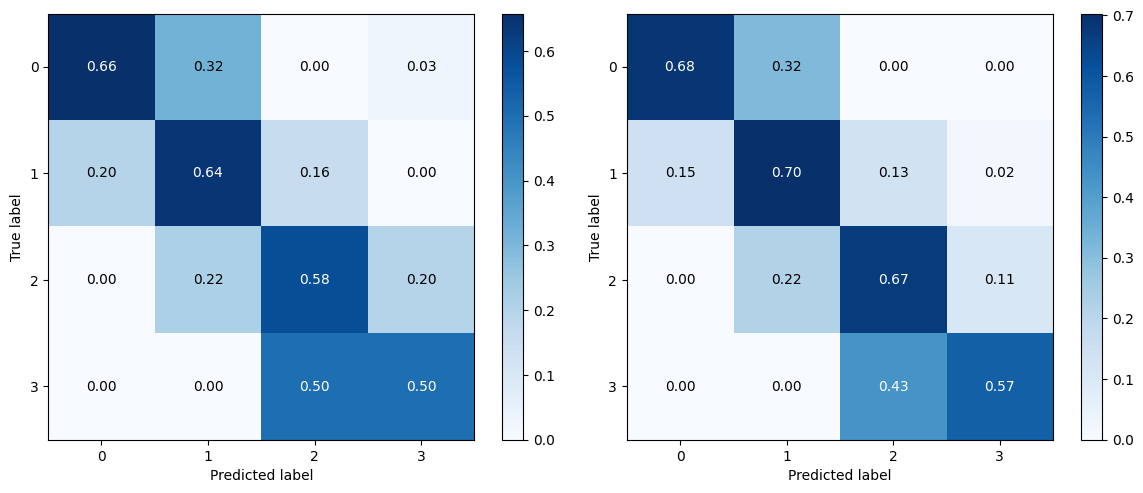

In [115]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
plot_confusion_matrix(results_pvwmh['cv_pred'][2], results_pvwmh['cv_pred'][3], fig, ax1)
plot_confusion_matrix(results_pvwmh['cvps+umap'][2], results_pvwmh['cvps+umap'][3], fig, ax2)

In [117]:

results_dwmh08 = {}
for model_type in model_types:
    if model_type == "cvpp":
        if entt == predt or entt==0.45:
            print("skipping cvpp due to parameters")
            continue
    results_acc = []
    results_balacc = []
    results = run_prediction_new(full_combined_df, model_type, clf=clf, thresholds_dict=thresholdsv2, colinear_threshold=0.8, n_splits=S, val_proportion=0.1, target="WMH_Deep", stratify_target="WMH_PV", 
                   rescale=True, predict_val=False, verbose=False, metric='accuracy', do_log=False, log_feature_matches=log_feature_matches, 
                   rem_colinear_feats=True, colinear_ignores=target_fields, regression=False)
    print(f"{model_type}, {results[0]:.2}, {results[1]:.2}")
    
    results_dwmh08[model_type] = results


clinical_only, 0.42, 0.38
c+volume, 0.58, 0.55
cv_pred0.5, 0.67, 0.65
cv_pred, 0.68, 0.65
cvp+samples, 0.67, 0.63
cv_umap, 0.62, 0.6
cvs_umap, 0.62, 0.59
cvps+umap, 0.66, 0.62


In [118]:
clf_reg = LinearRegression()
# clf_reg = Ridge(alpha=1)
# clf_reg = ARDRegression(n_iter=500, tol=0.001, alpha_1=1e-06, alpha_2=1e-06, 
#                         lambda_1=1e-06, lambda_2=1e-06, compute_score=False, threshold_lambda=10000.0, fit_intercept=True)
results_dwmh09 = {}
for model_type in model_types:
    if model_type == "cvpp":
        if entt == predt or entt==0.45:
            print("skipping cvpp due to parameters")
            continue
    results_acc = []
    results_balacc = []
    results = run_prediction_new(full_combined_df, model_type, clf=clf, thresholds_dict=thresholdsv2, colinear_threshold=0.9, n_splits=S, val_proportion=0.1, target="WMH_Deep", stratify_target="WMH_PV", 
                   rescale=True, predict_val=False, verbose=False, metric='accuracy', do_log=False, log_feature_matches=log_feature_matches, 
                   rem_colinear_feats=True, colinear_ignores=target_fields, regression=False)
    print(f"{model_type}, {results[0]:.2}, {results[1]:.2}")
    results_dwmh09[model_type] = results

clinical_only, 0.46, 0.42
c+volume, 0.58, 0.55
cv_pred0.5, 0.62, 0.61
cv_pred, 0.68, 0.65
cvp+samples, 0.66, 0.62
cv_umap, 0.62, 0.59
cvs_umap, 0.62, 0.59
cvps+umap, 0.65, 0.61


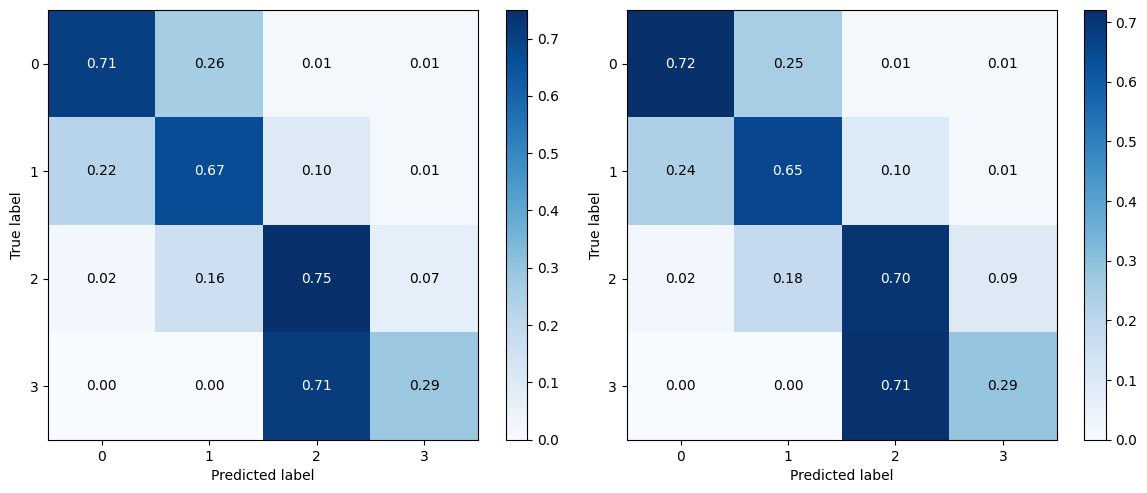

In [123]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
plot_confusion_matrix(results_dwmh08['cv_pred'][2], results_dwmh08['cv_pred'][3], fig, ax1)
plot_confusion_matrix(results_dwmh08['cvp+samples'][2], results_dwmh08['cvp+samples'][3], fig, ax2)

### training domain generalizatoin models

In [125]:
import pickle

In [139]:
def compute_accuracy_classification(clf, X, y):
    y_hat = clf.predict(X)
    y_target = y
    
    accuracy = accuracy_score(y_target, y_hat)
    # print(accuracy)
    accuracy = (y_hat == y_target).mean()
    # print(accuracy)

    class_preds = defaultdict(list)
    for yi in range(len(y_target)):
        yi_gt = y_target[yi]
        yi_hat = y_hat[yi]
        class_preds[yi_gt].append(yi_hat)
    # print(class_preds)
    class_preds = {yi: torch.Tensor(preds) for (yi, preds) in class_preds.items()}
    # print(class_preds)
    class_accs = [(preds == yi).sum().item()/preds.shape[0] for (yi, preds) in class_preds.items()]
    balanced_accuracy = torch.Tensor(class_accs).mean().item()
    
    return accuracy, balanced_accuracy, y_target, y_hat

In [140]:
def compute_accuracy_regression(clf, X, y):
    y_hat = clf.predict(X)
    y_target = y
    
    return np.mean(np.abs(y_target - y_hat)), 0.

In [141]:
target_fields = ['WMH_PV', 'WMH_Deep', 'Total', 'totatal_fazekas']

In [142]:
def train_final_model(df, model_type, thresholds_dict, clf, target="DWMH", label_categories=target_fields, 
                   rescale=True, do_log=False, log_feature_matches=None, 
                   rem_colinear_feats=False, colinear_threshold=0.8, colinear_ignores=target_fields, regression=False, stratify_target=None):
    verbose=False
    df = df.copy() # just to make sure I don't accidently modify the original at any point.
    
    # create the training data df
    df = load_model_df(df, model_type, **thresholds_dict)
    
    # run preprocessing on the data
    #df = shuffle(df)
    #print(df.keys().values)
    if do_log:
        df = shift_and_log_features(df, log_feature_matches, verbose=verbose)
    if rem_colinear_feats:
        remaining_keys = create_minimal_correlation_keys(df, ignore_keys=colinear_ignores, threshold=colinear_threshold, verbose=verbose)
        df = df[remaining_keys + colinear_ignores]
    X, y = extract_Xy(df, target, verbose, kept_column=stratify_target, label_categories=label_categories)
    X = X.reset_index()
    
    rescaler = None
    if rescale:
        rescaler = Rescaler()
        rescaler.fit(X)
        X = rescaler.predict(X)
    
    clf.fit(X, y)
    
    return X, y, clf, rescaler, remaining_keys

In [143]:
def load_and_evaluate_model(clf, rescaler, df, model_type, remaining_keys, target="DWMH", label_categories=target_fields, 
                   rescale=True, do_log=False, log_feature_matches=None, 
                   rem_colinear_feats=False, colinear_ignores=target_fields, regression=False, stratify_target=None):
    verbose=False
    df = df.copy() # just to make sure I don't accidently modify the original at any point.
    
    # create the training data df
    #df = load_model_df(df, model_type, **thresholds_dict)
    
    key_replace = {"AGE": "age", "PTGENDER": "sex"}
    columns = df.columns
    for key, new_key in key_replace.items():
        if key in columns:
            df[new_key] = df[key]
            df.drop(columns=key)
    
    # run preprocessing on the data
    #df = shuffle(df)
    #print(df.keys().values)
    if do_log:
        df = shift_and_log_features(df, log_feature_matches, verbose=verbose)
        
    if rem_colinear_feats:
        df = df[remaining_keys + colinear_ignores]
        
    # print("BEFORE HAND -----------")
    # print(df.keys())
    X, y = extract_Xy(df, target, verbose, kept_column=stratify_target, label_categories=label_categories)
    X = X.reset_index()
    # print("AFTER -----------------")
    # print(X.keys())
    
    if rescale:
        X = rescaler.predict(X)
    
    if regression:
        return compute_accuracy_regression(clf, X, y)
    else:
        return compute_accuracy_classification(clf, X, y)

In [148]:
def train_and_save_model(filename, target, thresholds_dict, colinear_threshold, stratify_target=None, regression=False):
    
    model_data = {}
    model_types = ["clinical_only","c+volume","cv_pred", "cv_pred0.5", "cvp+samples", "cv_umap", "cvs_umap","cvps+umap"]

    # PVWMH
    for model_type in model_types:
            if regression:
                clf = LinearRegression()
            else:
                clf = LogisticRegression(penalty='l2', dual=False, tol=0.1, C=0.1, fit_intercept=True, intercept_scaling=1, class_weight='balanced', 
                                     random_state=None, solver='lbfgs', max_iter=500, multi_class='multinomial', verbose=0, warm_start=False, n_jobs=None, l1_ratio=None)

            X, y, clf, rescaler, remaining_keys = train_final_model(full_combined_df, model_type, clf=clf, thresholds_dict=thresholds_dict, colinear_threshold=colinear_threshold, 
                                                                    target=target, rescale=True,  do_log=False, log_feature_matches=log_feature_matches, 
                           rem_colinear_feats=True, colinear_ignores=target_fields, regression=regression, stratify_target=stratify_target)

            model_data[model_type] = {"clf":clf, "rescaler": rescaler, "remaining_keys": remaining_keys}

            if not regression:
                results = compute_accuracy_classification(clf, X, y)
                print(f"{model_type}: {results[0]:.2}, {results[1]:.2}")
            else:
                mae, _ = compute_accuracy_regression(clf, X, y)
                print(f"{model_type}: {mae:.2}")
                
    with open(f'saved_models/{filename}.model', 'wb') as handle:
        pickle.dump(model_data, handle, protocol=pickle.HIGHEST_PROTOCOL)

    with open(f'saved_models/{filename}.model', 'rb') as pickle_file:
        content = pickle.load(pickle_file)

    print("\nassess that saved model has the same performance")

    for key in content:
        data = content[key]
        results = load_and_evaluate_model(data['clf'], data['rescaler'], full_combined_df, model_type=key, remaining_keys = data['remaining_keys'],
                       target=target, label_categories=target_fields, 
                       rescale=True, do_log=False, log_feature_matches=None, 
                       rem_colinear_feats=True, colinear_ignores=target_fields, regression=regression, stratify_target=stratify_target)
        print(f"{model_type}, {results[0]:.2}, {results[1]:.2}")

In [149]:
clinical_fields = ['PTGENDER']

In [150]:
# clinical_fields = ['sbjGroup', 'age', 'sex',
#  'diabetes', 'hypertension', 'hyperlipidaemia',
#        'smoking_0', 'smoking_1', 'smoking_2']
# ICV is a bad feature that breaks things!!!
#clinical_fields = ['PTGENDER']

In [151]:
train_and_save_model('CHAL_BASED_ADNI_PVWMH', target="WMH_PV", thresholds_dict = thresholdsv1, colinear_threshold = ct1)

clinical_only: 0.18, 0.33
c+volume: 0.58, 0.71
cv_pred: 0.71, 0.76
cv_pred0.5: 0.74, 0.79
cvp+samples: 0.75, 0.81
cv_umap: 0.67, 0.76
cvs_umap: 0.7, 0.79
cvps+umap: 0.76, 0.82

assess that saved model has the same performance
cvps+umap, 0.18, 0.33
cvps+umap, 0.58, 0.71
cvps+umap, 0.71, 0.76
cvps+umap, 0.74, 0.79
cvps+umap, 0.75, 0.81
cvps+umap, 0.67, 0.76
cvps+umap, 0.7, 0.79
cvps+umap, 0.76, 0.82


In [152]:
train_and_save_model('CHAL_BASED_ADNI_DWMH_0.8', target="WMH_Deep", thresholds_dict = thresholdsv2, colinear_threshold = 0.8)

clinical_only: 0.3, 0.33
c+volume: 0.57, 0.68
cv_pred: 0.72, 0.81
cv_pred0.5: 0.71, 0.81
cvp+samples: 0.73, 0.82
cv_umap: 0.71, 0.8
cvs_umap: 0.71, 0.81
cvps+umap: 0.78, 0.86

assess that saved model has the same performance
cvps+umap, 0.3, 0.33
cvps+umap, 0.57, 0.68
cvps+umap, 0.72, 0.81
cvps+umap, 0.71, 0.81
cvps+umap, 0.73, 0.82
cvps+umap, 0.71, 0.8
cvps+umap, 0.71, 0.81
cvps+umap, 0.78, 0.86


In [124]:
train_and_save_model('CHAL_BASED_ADNI_DWMH_0.9', target="WMH_Deep", thresholds_dict = thresholdsv2, colinear_threshold = 0.9)

clinical_only: 0.3, 0.33
c+volume: 0.57, 0.68
cv_pred: 0.72, 0.81
cv_pred0.5: 0.72, 0.83
cvp+samples: 0.72, 0.81
cv_umap: 0.72, 0.81
cvs_umap: 0.74, 0.82
cvps+umap: 0.78, 0.86

assess that saved model has the same performance
clinical_only: 0.3, 0.33
c+volume: 0.57, 0.68
cv_pred: 0.72, 0.81
cv_pred0.5: 0.72, 0.83
cvp+samples: 0.72, 0.81
cv_umap: 0.72, 0.81
cvs_umap: 0.74, 0.82
cvps+umap: 0.78, 0.86


In [125]:
train_and_save_model('CHAL_BASED_ADNI_total_fazekas', target="Total", thresholds_dict = thresholdsv1, colinear_threshold = ct1)

clinical_only: 0.13, 0.28
c+volume: 0.38, 0.5
cv_pred: 0.5, 0.65
cv_pred0.5: 0.5, 0.65
cvp+samples: 0.56, 0.7
cv_umap: 0.49, 0.63
cvs_umap: 0.51, 0.65
cvps+umap: 0.57, 0.72

assess that saved model has the same performance
clinical_only: 0.13, 0.28
c+volume: 0.38, 0.5
cv_pred: 0.5, 0.65
cv_pred0.5: 0.5, 0.65
cvp+samples: 0.56, 0.7
cv_umap: 0.49, 0.63
cvs_umap: 0.51, 0.65
cvps+umap: 0.57, 0.72


In [127]:
#train_and_save_model('CHAL_BASED_ADNI_age', target="AGE", thresholds_dict = thresholdsv1, colinear_threshold = ct1, regression=True)

In [128]:
train_and_save_model('CHAL_BASED_ADNI_sex', target="PTGENDER", thresholds_dict = thresholdsv1, colinear_threshold = ct1, regression=True)

clinical_only: 0.5
c+volume: 0.44
cv_pred: 0.41
cv_pred0.5: 0.42
cvp+samples: 0.41
cv_umap: 0.42
cvs_umap: 0.41
cvps+umap: 0.39

assess that saved model has the same performance
clinical_only: 0.5, 0.0
c+volume: 0.44, 0.0
cv_pred: 0.41, 0.0
cv_pred0.5: 0.42, 0.0
cvp+samples: 0.41, 0.0
cv_umap: 0.42, 0.0
cvs_umap: 0.41, 0.0
cvps+umap: 0.39, 0.0


### Evaluating the models trained on the CVD dataset

In [153]:
def load_and_save_all_models(filename, target, stratify_target=None, regression=False, seg_eval_ds="CVD"):
    with open(f'saved_models/{filename}.model', 'rb') as pickle_file:
        content = pickle.load(pickle_file)

    model_type_name_map = {"clinical_only":"C","c+volume":"CV","cv_pred":"CVP", "cv_pred0.5":"CVP0.5", "cvp+samples":"CVPS", "cv_umap":"CVH", "cvs_umap":"CVSH","cvps+umap":"CVPSH"}
        
    print("\nassess that saved model has the same performance")

    model_results = {}
    
    for key in content:
        data = content[key]
        #print(data['remaining_keys'])
        acc, balanced_acc, targets, preds = load_and_evaluate_model(data['clf'], data['rescaler'], full_combined_df, model_type=key, remaining_keys = data['remaining_keys'],
                       target=target, label_categories=target_fields, 
                       rescale=True, do_log=False, log_feature_matches=None, 
                       rem_colinear_feats=True, colinear_ignores=target_fields, regression=regression, stratify_target=stratify_target)
        print(f"{key}: {acc:.2}, {balanced_acc:.2}")
        model_results[key] = (acc, balanced_acc, targets, preds)
        
#         with open("generalization_tests_results.csv", "a") as f:
#             model_name = model_type_name_map[key]
            
#             if "CHAL" in filename:
#                 wmh_seg_train_ds = "WMH Challenge"
#             else:
#                 wmh_seg_train_ds = "CVD"
                
            
#             if "ADNI" in filename:
#                 fazekas_pred_ds = "ADNI"
#                 fazekas_eval_ds = "CVD"
#             else:
#                 fazekas_pred_ds = "CVD"
#                 fazekas_eval_ds = "ADNI"
                
            #f.write(f"{model_name}, {wmh_seg_train_ds}, {fazekas_pred_ds}, {fazekas_eval_ds}, {seg_eval_ds}, {target}, {filename}, {acc:.2}, {balanced_acc:.2}\n")
    return model_results

In [155]:
pvwmh_results = load_and_save_all_models("CVD_PVWMH", "WMH_PV")


assess that saved model has the same performance
clinical_only: 0.12, 0.27
c+volume: 0.26, 0.46
cv_pred: 0.64, 0.57
cv_pred0.5: 0.6, 0.57
cvp+samples: 0.66, 0.39
cv_umap: 0.6, 0.49
cvs_umap: 0.65, 0.5
cvps+umap: 0.71, 0.42


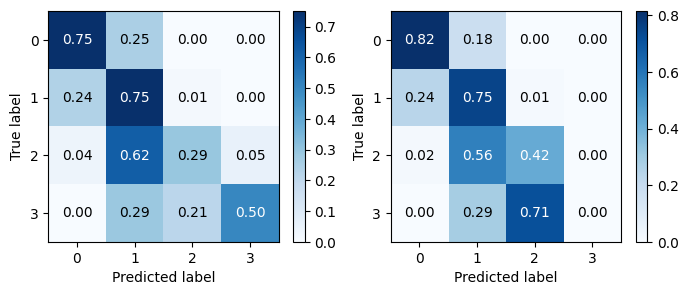

In [172]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(7, 3))
plot_confusion_matrix(pvwmh_results['cv_pred'][2], pvwmh_results['cv_pred'][3], fig, ax1)
plot_confusion_matrix(pvwmh_results['cvs_umap'][2], pvwmh_results['cvs_umap'][3], fig, ax2)

In [157]:
dwmh_results08 =  load_and_save_all_models("CVD_DWMH_0.8", "WMH_Deep")


assess that saved model has the same performance
clinical_only: 0.26, 0.23
c+volume: 0.38, 0.36
cv_pred: 0.57, 0.55
cv_pred0.5: 0.51, 0.52
cvp+samples: 0.42, 0.4
cv_umap: 0.51, 0.54
cvs_umap: 0.49, 0.5
cvps+umap: 0.49, 0.53


In [158]:
dwmh_results09 = load_and_save_all_models("CVD_DWMH_0.9", "WMH_Deep")


assess that saved model has the same performance
clinical_only: 0.26, 0.23
c+volume: 0.38, 0.36
cv_pred: 0.59, 0.57
cv_pred0.5: 0.5, 0.49
cvp+samples: 0.4, 0.41
cv_umap: 0.53, 0.53
cvs_umap: 0.41, 0.45
cvps+umap: 0.41, 0.51


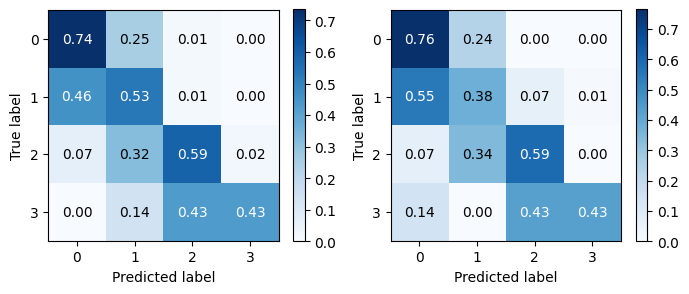

In [171]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(7, 3))
plot_confusion_matrix(dwmh_results09['cv_pred'][2], dwmh_results09['cv_pred'][3], fig, ax1)
plot_confusion_matrix(dwmh_results08['cv_umap'][2], dwmh_results08['cv_umap'][3], fig, ax2)

In [161]:
#load_and_save_all_models("CVD_total_fazekas", "Total")

In [163]:
#load_and_save_all_models("CVD_sex", "sex", regression=True)

### Try the models trained on the uncertainty maps trained on the WMH Challenge dataset

In [164]:
pvwmh_results_chal_based =load_and_save_all_models("CHAL_BASED_CVD_PVWMH", "WMH_PV")


assess that saved model has the same performance
clinical_only: 0.13, 0.29
c+volume: 0.31, 0.49
cv_pred: 0.6, 0.53
cv_pred0.5: 0.56, 0.54
cvp+samples: 0.33, 0.39
cv_umap: 0.56, 0.53
cvs_umap: 0.58, 0.46
cvps+umap: 0.65, 0.38


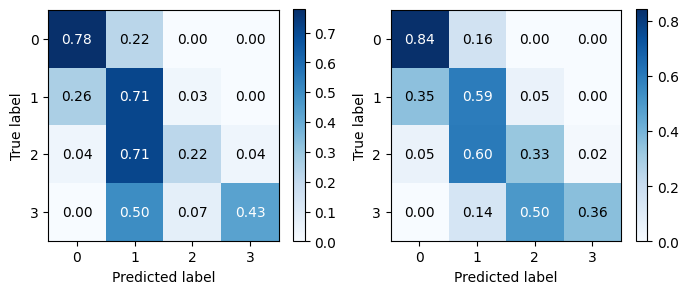

In [166]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(7, 3))
plot_confusion_matrix(pvwmh_results_chal_based['cv_pred'][2], pvwmh_results_chal_based['cv_pred'][3], fig, ax1)
plot_confusion_matrix(pvwmh_results_chal_based['cv_umap'][2], pvwmh_results_chal_based['cv_umap'][3], fig, ax2)

In [167]:
pvwmh_results_chal_based08 = load_and_save_all_models("CHAL_BASED_CVD_DWMH_0.8", "WMH_Deep")


assess that saved model has the same performance
clinical_only: 0.28, 0.23
c+volume: 0.38, 0.39
cv_pred: 0.53, 0.43
cv_pred0.5: 0.53, 0.47
cvp+samples: 0.38, 0.4
cv_umap: 0.59, 0.52
cvs_umap: 0.42, 0.5
cvps+umap: 0.58, 0.47


In [168]:
pvwmh_results_chal_based09 = load_and_save_all_models("CHAL_BASED_CVD_DWMH_0.9", "WMH_Deep")


assess that saved model has the same performance
clinical_only: 0.28, 0.23
c+volume: 0.38, 0.39
cv_pred: 0.53, 0.44
cv_pred0.5: 0.54, 0.49
cvp+samples: 0.4, 0.45
cv_umap: 0.55, 0.51
cvs_umap: 0.42, 0.52
cvps+umap: 0.58, 0.59


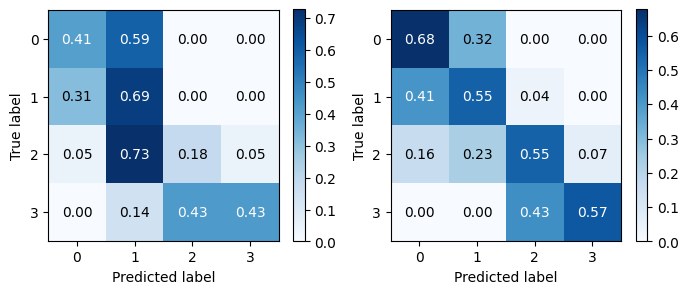

In [170]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(7, 3))
plot_confusion_matrix(pvwmh_results_chal_based08['cv_pred'][2], pvwmh_results_chal_based08['cv_pred'][3], fig, ax1)
plot_confusion_matrix(pvwmh_results_chal_based09['cvps+umap'][2], pvwmh_results_chal_based09['cvps+umap'][3], fig, ax2)

In [216]:
load_and_save_all_models("CHAL_BASED_CVD_total_fazekas", "Total")


assess that saved model has the same performance
clinical_only: 0.2, 0.14
c+volume: 0.2, 0.17
cv_pred: 0.18, 0.18
cv_pred0.5: 0.19, 0.16
cvp+samples: 0.21, 0.21
cv_umap: 0.21, 0.25
cvs_umap: 0.2, 0.27
cvps+umap: 0.3, 0.26


In [217]:
load_and_save_all_models("CHAL_BASED_CVD_sex", "sex", regression=True)


assess that saved model has the same performance
clinical_only: 0.55, 0.0
c+volume: 0.46, 0.0
cv_pred: 0.48, 0.0
cv_pred0.5: 0.47, 0.0
cvp+samples: 0.48, 0.0
cv_umap: 0.52, 0.0
cvs_umap: 0.51, 0.0
cvps+umap: 0.55, 0.0
